### Task 1

#### 1) Точки поломки

a) 2. Объяснение: классификатор x≥a может разметить верно только 1 точку. Пример: x < y, x принадлежит к классу +1, y принадлежит к классу -1.

б) 3. Объяснение: классификатор a≥x≥b может разметить верно только 2 точки, накрыв их обе интервалом, одну из них или никакую. При 3 точках может возникнуть ситуация, в которой один интервал не поможет: x < y < z; x,z принадлежат классу +1, а y - классу -1. 

### Tasks 2-3

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [2]:
class PerceptronWithAPocket():
    def __init__(self, lr=0.01, max_iterations=1000):
        self.lr = lr
        self.max_iterations = max_iterations
        self.pocket_W = None
        self.pocket_accuracy = None
    
    def fit(self, X, y):
        # Here we add the fake column to simplify calculations
        X_ = np.concatenate((np.ones([X.shape[0], 1]), X), axis=1) # shape: [n, m_features+1]
        W = np.ones([X.shape[1]+1, 1]) * 0.0001 # shape: [m_features+1, 1]
        predictions = np.sign(np.dot(X_, W))
        iterations = 1
        accuracy_v = []
        while(iterations < self.max_iterations):
            not_equal_idx = np.argwhere(predictions.flatten() != y).flatten()
            update_idx = np.random.randint(0, not_equal_idx.shape[0])
            W = W + self.lr * (X_[update_idx] * y[update_idx]).reshape(W.shape)
            predictions = np.sign(np.dot(X_, W))
            accuracy = accuracy_score(predictions, y)
            accuracy_v.append(accuracy)
            iterations += 1
            if not self.pocket_accuracy or accuracy > self.pocket_accuracy:
                self.pocket_accuracy = accuracy
                self.pocket_W = np.copy(W)
        return self.pocket_W, self.pocket_accuracy, accuracy_v
    
    def predict(self, X):
        X_ = np.concatenate((np.ones([X.shape[0], 1]), X), axis=1)
        return np.sign(np.dot(X_, self.pocket_W))

In [3]:
def separating_line_2d(x, w0, w1, w2):
    return (-w1*x - w0)/w2

### 2 features: x, y

In [59]:
df = pd.read_csv('../data/blobs2.csv')
df.label = df.label.map(lambda y: y if y == 1 else -1)
X = df[df.columns.difference(['label'])].values
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Accuracy per iteration, lr: 1e-06, pocket acc: 0.96625')

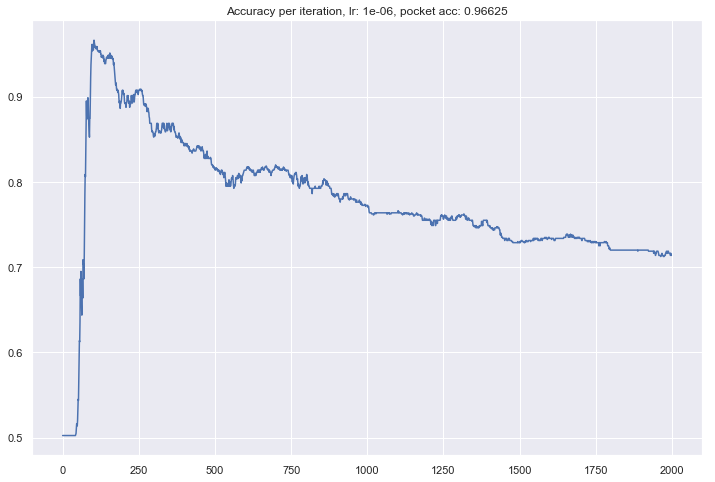

In [60]:
lr = 1e-6
pwap = PerceptronWithAPocket(lr=lr, max_iterations=2000)
pocket_W, pocket_accuracy, accuracy_v = pwap.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_v)), accuracy_v)
plt.title(f"Accuracy per iteration, lr: {lr}, pocket acc: {pocket_accuracy}")

In [61]:
print("W:")
print(f"{pocket_W}")

W:
[[ 8.80000000e-05]
 [ 1.48272922e-04]
 [-1.13263936e-04]]


Text(0.5, 1.0, 'Test dataset, 2 features, test acc: 0.935')

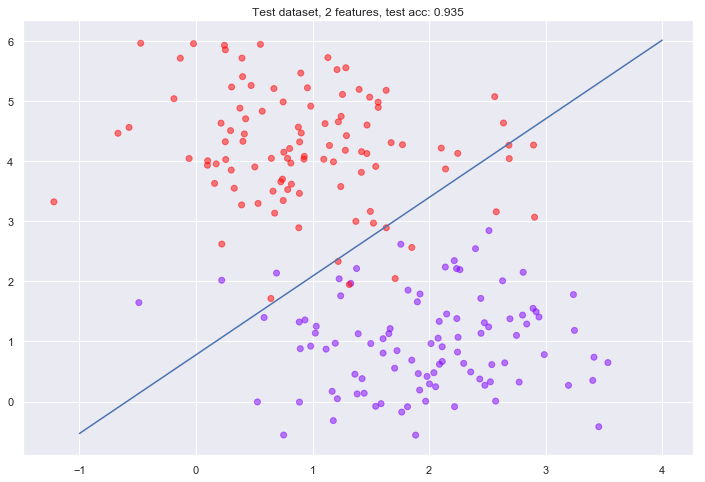

In [62]:
predictions=pwap.predict(X_test)
test_accuracy = accuracy_score(predictions, y_test)
colors = [0 if yi == -1 else 1 for yi in y_test]
w0, w1, w2 = pocket_W[0][0], pocket_W[1][0], pocket_W[2][0]
plt.figure(figsize=(12, 8))
plt.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='rainbow_r', alpha=0.5)
plt.plot([-1, 4], [separating_line_2d(-1, w0, w1, w2), separating_line_2d(4, w0, w1, w2)])
plt.title(f"Test dataset, 2 features, test acc: {test_accuracy}")

### 5 features: x, y, x^2, y^2, xy

Text(0.5, 1.0, 'Accuracy per iteration, lr: 1e-06, pocket acc: 0.9675')

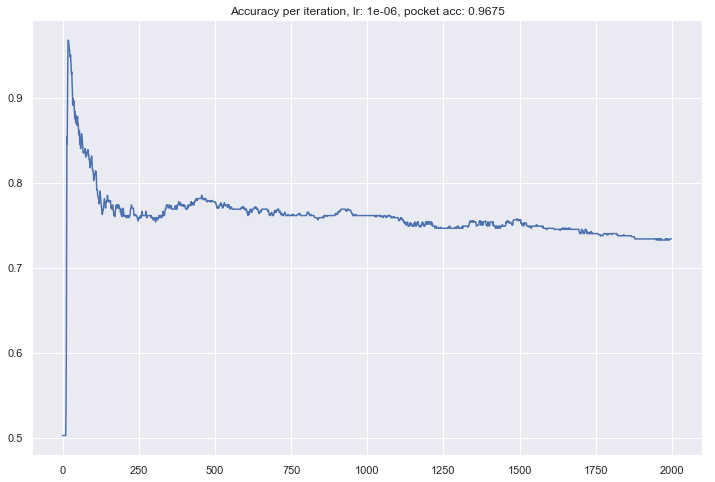

In [78]:
df = pd.read_csv('../data/blobs2.csv')
df.label = df.label.map(lambda y: y if y == 1 else -1)
df['x_'] = df.x * df.x
df['y_'] = df.y * df.y
df['xy'] = df.x * df.y
X = df[['x', 'y', 'x_', 'y_', 'xy']].values
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = 1e-6
pwap = PerceptronWithAPocket(lr=lr, max_iterations=2000)
pocket_W, pocket_accuracy, accuracy_v = pwap.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_v)), accuracy_v)
plt.title(f"Accuracy per iteration, lr: {lr}, pocket acc: {pocket_accuracy}")

In [79]:
print("W:")
print(f"{pocket_W}")

W:
[[ 9.10000000e-05]
 [ 1.00147886e-04]
 [ 5.11500627e-05]
 [ 1.07280532e-04]
 [-1.17739375e-04]
 [ 7.18789339e-05]]


Text(0.5, 1.0, 'Test dataset, 5 features (2nd degree), test acc: 0.93')

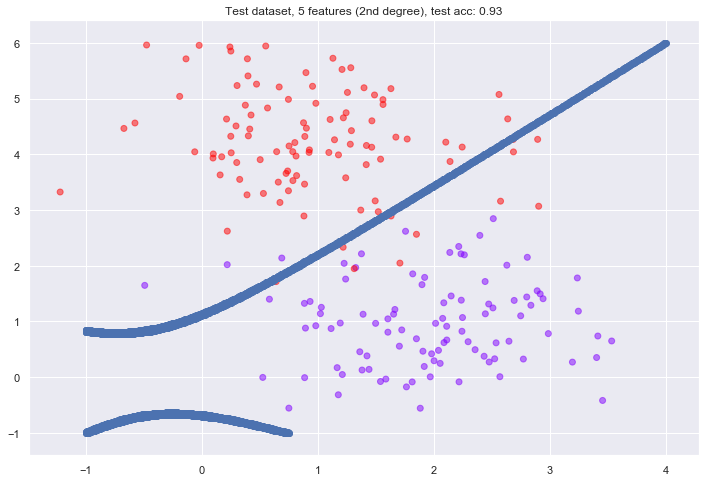

In [80]:
predictions=pwap.predict(X_test)
test_accuracy = accuracy_score(predictions, y_test)
colors = [0 if yi == -1 else 1 for yi in y_test]
plt.figure(figsize=(12, 8))
plt.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='rainbow_r', alpha=0.5)

# draw curve
w0, w1, w2, w3, w4, w5 = pocket_W
x_v = []
y_v = []
for x in np.linspace(-1, 4, 1000):
    for y in np.linspace(-1, 7, 1000):
        v = w0 + w1*x + w2*y + w3*x**2 + w4*y**2 + w5*x*y
        if np.abs(v) < 5e-6:
            x_v.append(x)
            y_v.append(y)

plt.scatter(x_v, y_v)
plt.title(f"Test dataset, 5 features (2nd degree), test acc: {test_accuracy}")

### 5 features: x, y, x^3, y^3, xy

Text(0.5, 1.0, 'Accuracy per iteration, lr: 1e-06, pocket acc: 0.96125')

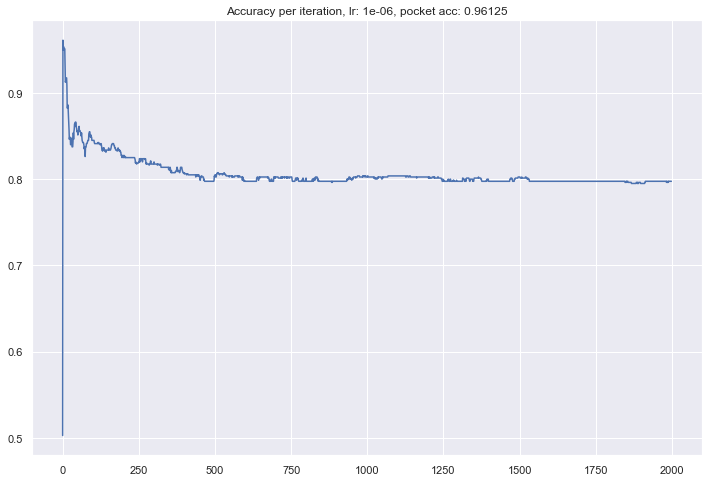

In [81]:
df = pd.read_csv('../data/blobs2.csv')
df.label = df.label.map(lambda y: y if y == 1 else -1)
df['x_'] = df.x**3
df['y_'] = df.y**3
df['xy'] = df.x * df.y
X = df[['x', 'y', 'x_', 'y_', 'xy']].values
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = 1e-6
pwap = PerceptronWithAPocket(lr=lr, max_iterations=2000)
pocket_W, pocket_accuracy, accuracy_v = pwap.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_v)), accuracy_v)
plt.title(f"Accuracy per iteration, lr: {lr}, pocket acc: {pocket_accuracy}")

In [82]:
print("W:")
print(f"{pocket_W}")

W:
[[ 9.80000000e-05]
 [ 9.84733432e-05]
 [ 9.08436457e-05]
 [ 9.42559952e-05]
 [-1.12009798e-04]
 [ 9.12495510e-05]]


Text(0.5, 1.0, 'Test dataset, 5 features (3d degree), test acc: 0.955')

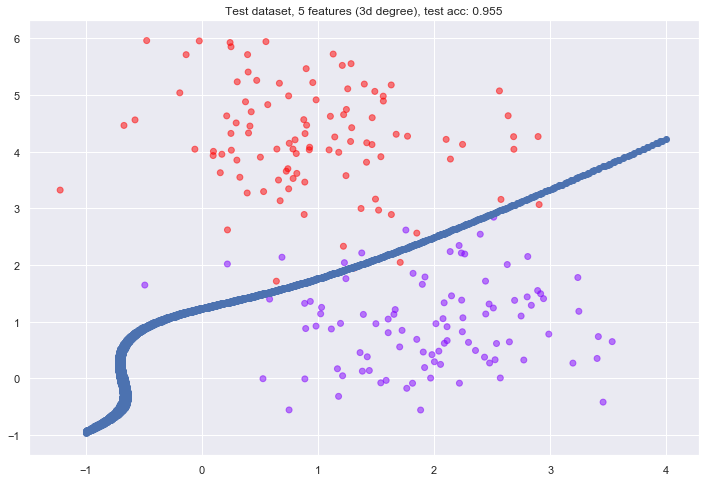

In [83]:
predictions=pwap.predict(X_test)
test_accuracy = accuracy_score(predictions, y_test)
colors = [0 if yi == -1 else 1 for yi in y_test]
plt.figure(figsize=(12, 8))
plt.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='rainbow_r', alpha=0.5)

# draw curve
w0, w1, w2, w3, w4, w5 = pocket_W
x_v = []
y_v = []
for x in np.linspace(-1, 4, 1000):
    for y in np.linspace(-1, 7, 1000):
        v = w0 + w1*x + w2*y + w3*x**3 + w4*y**3 + w5*x*y
        if np.abs(v) < 5e-6:
            x_v.append(x)
            y_v.append(y)

plt.scatter(x_v, y_v)
plt.title(f"Test dataset, 5 features (3d degree), test acc: {test_accuracy}")

### 5 features: x, y, x^4, y^4, xy

Text(0.5, 1.0, 'Accuracy per iteration, lr: 1e-06, pocket acc: 0.87125')

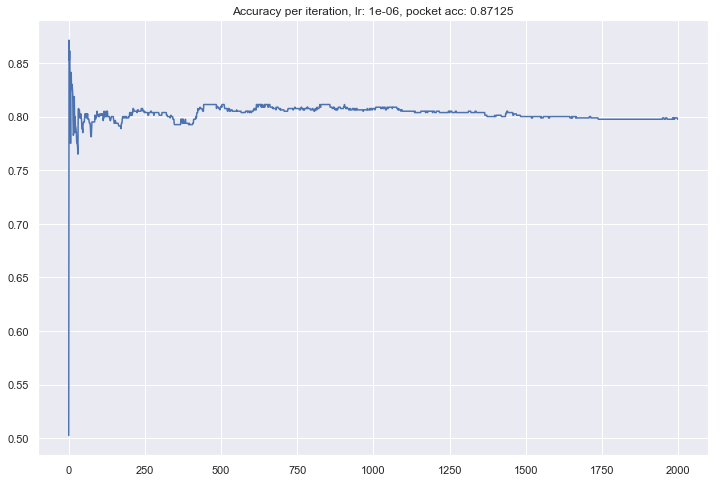

In [84]:
df = pd.read_csv('../data/blobs2.csv')
df.label = df.label.map(lambda y: y if y == 1 else -1)
df['x_'] = df.x**4
df['y_'] = df.y**4
df['xy'] = df.x * df.y
X = df[['x', 'y', 'x_', 'y_', 'xy']].values
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = 1e-6
pwap = PerceptronWithAPocket(lr=lr, max_iterations=2000)
pocket_W, pocket_accuracy, accuracy_v = pwap.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(accuracy_v)), accuracy_v)
plt.title(f"Accuracy per iteration, lr: {lr}, pocket acc: {pocket_accuracy}")

In [85]:
print("W:")
print(f"{pocket_W}")

W:
[[ 9.80000000e-05]
 [ 9.81023433e-05]
 [ 9.19650664e-05]
 [ 9.46364259e-05]
 [-6.53112137e-04]
 [ 9.36200329e-05]]


Text(0.5, 1.0, 'Test dataset, 5 features (3d degree), test acc: 0.855')

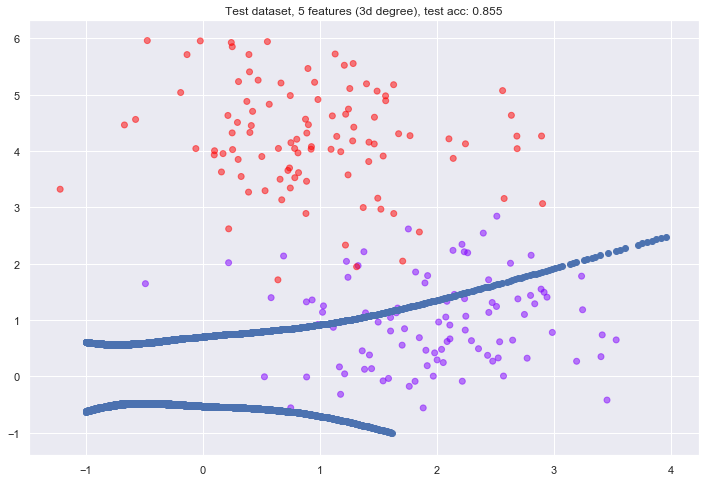

In [86]:
predictions=pwap.predict(X_test)
test_accuracy = accuracy_score(predictions, y_test)
colors = [0 if yi == -1 else 1 for yi in y_test]
plt.figure(figsize=(12, 8))
plt.scatter(X_test[:,0], X_test[:,1], c=colors, cmap='rainbow_r', alpha=0.5)

# draw curve
w0, w1, w2, w3, w4, w5 = pocket_W
x_v = []
y_v = []
for x in np.linspace(-1, 4, 2000):
    for y in np.linspace(-1, 7, 1000):
        v = w0 + w1*x + w2*y + w3*x**4 + w4*y**4 + w5*x*y
        if np.abs(v) < 5e-6:
            x_v.append(x)
            y_v.append(y)

plt.scatter(x_v, y_v)
plt.title(f"Test dataset, 5 features (3d degree), test acc: {test_accuracy}")

Вывод. Cамый высокий accuracy на тестовой выборке дал вариант фичей: x, y, x^3, y^3, xy